# Splot: Exploring Spatial Autocorrelation with Mask option

Content:
1. Imports
2. Statistical data pre-processing
3. Lisa cluster map functionality
4. Three plot combination with region mask

## Imports

In [2]:
%matplotlib inline 

import matplotlib.pyplot as plt
import pysal as ps
import libpysal.api as lp
import numpy as np
import geopandas as gpd
import os
import splot
import splot.plot
import esda
from pysal.contrib.pdio import read_files

In [69]:
from importlib import reload

reload(splot.plot)

<module 'splot.plot' from '/Users/steffie/code/splot/splot/plot.py'>

## Example Data

First, we will load the Guerry.shp data from the example_data folder.

In [3]:
link_to_data = os.path.join('..', 'example_data', 'guerry', 'Guerry.shp')
df = gpd.read_file(link_to_data)

For this example we will focus on the Donatns (charitable donations per capita) variable. We will calculate Contiguity weights `w` with `ps.queen_from_shapefile()`. Then we transform our weights to be row-standardized. Lastly we calculate moran and moran_loc values, used as input for the visualizations.

In [4]:
y = df['Donatns'].values
w = lp.Queen.from_dataframe(df)
w.transform = 'r'

moran = esda.moran.Moran(y, w)
moran_loc = esda.moran.Moran_Local(y, w)

We would now like to visually explore our data for specific regions. Region names are stored under `Dprtmnt` in our dataframe. 

In [5]:
region = df['Dprtmnt']
region.head()

0             Ain
1           Aisne
2          Allier
3    Basses-Alpes
4    Hautes-Alpes
Name: Dprtmnt, dtype: object

### In order to load the three-plot visualization we need to load the new lisa_cluster functionality

In [108]:
def lisa_cluster(moran_loc, df, p=0.05, figsize=None, ax=None, legend=True, legend_kwds=None, ):
    
    import geopandas as gdp
    from matplotlib import colors

    sig = 1 * (moran_loc.p_sim < p)
    HH = 1 * (sig * moran_loc.q==1)
    LL = 3 * (sig * moran_loc.q==3)
    LH = 2 * (sig * moran_loc.q==2)
    HL = 4 * (sig * moran_loc.q==4)
    
    spots = HH + LL + LH + HL
    spot_labels = [ '0 ns', '1 HH', '2 LH', '3 LL', '4 HL']
    labels = [spot_labels[i] for i in spots]
    
    hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
    
    if ax is None:
        f, ax = plt.subplots(1, figsize=figsize)
    else:
        fig = ax.get_figure()
    
    df.assign(cl=labels).plot(column='cl', categorical=True,
        k=2, cmap=hmap, linewidth=0.1, ax=ax,
        edgecolor='white', legend=legend, legend_kwds=legend_kwds)
    ax.set_axis_off()
    
    return plt

### Example:

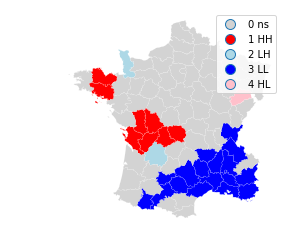

In [109]:
lisa_cluster(moran_loc, df, p=0.05, figsize = (4,4))

plt.show()

## Visualizing Local Autocorrelation with splot - exploring specific regions

In [121]:
import matplotlib.pyplot as plt
import numpy as np
from geopandas.plotting import plot_dataframe
from importlib import reload
reload(splot)

def plot_local_autocorrelation(m, df, attribute, figsize=(15, 4), region_column=None,
                               mask=None, mask_color='gold', p=0.05, legend=True, scheme='Quantiles', cmap='GnBu'):
    '''
    Produce three-plot visualization with region mask
    
    Parameters
    ----------
    m : esda.moran.Moran or esda.moran.Moran_Local instance
        Values of Moran's I Global Autocorrelation Statistic
    df : geopandas dataframe
        The Dataframe to plot the two maps.
    attribute : str
        Column name of attribute which should be depicted in Chloropleth map.
    figsize: tuple, optional
        W, h of figure. Default = (15,4)
    region_column: string, optional
        Column name containing mask region of interest. Default = None
    mask: str, optional
        Identifier or name of the region to highlight. Default = None
    mask_color: str, optional
        Color of mask. Default = 'gold'
    p : float, optional
        The p-value threshold for significance. Points and polygons will
        be colored by significance. Default = 0.05.
    legend: boolean, optional
        If True, legend for maps will be depicted. Default = True
    scheme: str, optional
        Name of PySAL classifier to be used. Default = 'Quantiles'
    cmap: str, optional
        Name of matplotlib colormap used for plotting the Choropleth. Default = 'GnBU'
    
    Returns
    -------
    fig : Matplotlib figure instance
        Moran Scatterplot, LISA cluster map and Choropleth
    
        '''
    # TODO:
    # fix unary_union.boundary call
    
    
    fig, axs = plt.subplots(1, 3, figsize=figsize,
                            subplot_kw={'aspect':'equal'})
    #Moran Scatterplot
    splot.plot.mplot(m, xlabel='Response', ylabel='Spatial Lag',
                     title='Moran Scatterplot', p=p, ax=axs[0])
 
    # masking inside axs[0] or Moran Scatterplot
    if region_column is not None:
        ix = df[region_column].isin(mask)
        #df[region_column] == mask
        df_mask = df[ix]
        x_mask = m.z[ix]
        y_mask = ps.lag_spatial(m.w, m.z)[ix]
        axs[0].plot(x_mask, y_mask, color=mask_color, marker='o', markersize=14, alpha=.8, zorder=-1)
        axs[0].set_aspect('auto')
    
    # Lisa cluster map
    #TODO: Fix legend_kwds: display boxes instead of points, 
    #get rid of 0-4 in lisa_cluster
    lisa_cluster(m, df, p=p, ax=axs[1], legend=legend,
                 legend_kwds={'loc': 'upper left', 
                              'bbox_to_anchor': (0.92, 1.05)})
    #masking inside axs[1] or Lisa cluster map
    if region_column is not None:
        union = df_mask.unary_union.boundary
        gpd.GeoSeries([union]).plot(linewidth=2, ax=axs[1], color=mask_color)
    
    #Choropleth for attribute
    df.plot(column=attribute, scheme=scheme, cmap=cmap,
            legend=legend, legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (0.92, 1.05)}, ax=axs[2])
    axs[2].set_axis_off()
    
    #masking inside axs[2] or Chloropleth
    if region_column is not None:
        gpd.GeoSeries([union]).plot(linewidth=2, ax=axs[2], color=mask_color)
    
    return fig

exlpore values for different regions in France, e.g. 'Rhone', 'Hautes-Alpes', ...

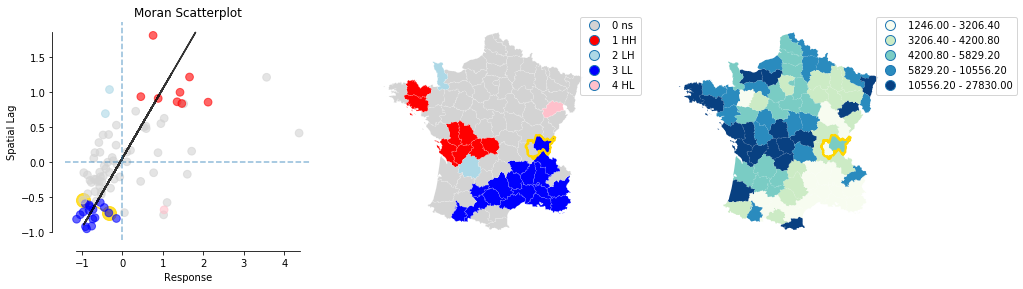

In [122]:
plot_local_autocorrelation(moran_loc, df, "Donatns", region_column='Dprtmnt', mask=['Rhone', 'Ain'], legend=True)
#plot_local_autocorrelation(moran_loc, df, "Donatns", legend=True)

plt.show()

In [115]:
# Check if slowe is correct:
# this is the expression used in mplot
# this seems to be correct for both moran and moran_local so no change towards: 
# ps.Moran(y,W).I == ps.Moran_Local(y,W).Is.sum() / (W.n-1) needed
# please double check
m = moran_loc
lag = ps.lag_spatial(m.w, m.z)
fit = ps.spreg.OLS(m.z[:, None], lag[:,None])
print('Slope = ', np.mean(lag / fit.predy))

Slope =  0.2155932712177522


In [82]:
ps.Moran(y,w).I

0.3533613255848606

In [85]:
ps.Moran_Local(y,w).Is.sum() / (w.n-1)

0.35336132558486066

In [120]:
check = fit.predy